In [7]:
import pandas as pd
import numpy as np
import requests
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier

def get_all_categories(df1, df2, categorical_columns):
    all_categories = {}
    for column in categorical_columns:
        all_categories[column] = sorted(set(df1[column].unique()) | set(df2[column].unique()))
    return all_categories

def get_dataset(df, all_categories):
    df.replace("?", np.nan, inplace=True)
    df.dropna(inplace=True)
    df['income'] = df['income'].map({'>50K': 1, '<=50K': 0, '>50K.': 1, '<=50K.': 0})
    for column in all_categories:
        df[column] = pd.Categorical(df[column], categories=all_categories[column])
    df = pd.get_dummies(df, columns=list(all_categories.keys()))
    return df

column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income']


# Read and clean the adult.data
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
df_train_raw = pd.read_csv(data_url, header=None, names=column_names, delimiter=', ', engine='python')

# Read and clean the adult.test
test_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"
df_test_raw = pd.read_csv(test_url, header=None, names=column_names, delimiter=', ', engine='python', skiprows=1)

categorical_columns = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']
all_categories = get_all_categories(df_train_raw, df_test_raw, categorical_columns)

df_train = get_dataset(df_train_raw, all_categories)
df_test = get_dataset(df_test_raw, all_categories)

# Separate the features (X) and the target (y) in both datasets
X_train = df_train.drop('income', axis=1)
y_train = df_train['income']
X_test = df_test.drop('income', axis=1)
y_test = df_test['income']

# Train and evaluate Logistic Regression model
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

print("Logistic Regression Model")
print("Accuracy:", accuracy_score(y_test, lr_pred))
print(classification_report(y_test, lr_pred))

# Train and evaluate Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

print("Random Forest Model")
print("Accuracy:", accuracy_score(y_test, rf_pred))
print(classification_report(y_test, rf_pred))

# Train and evaluate K-Nearest Neighbors Classifier model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)

print("K-Nearest Neighbors Classifier Model")
print("Accuracy:", accuracy_score(y_test, knn_pred))
print(classification_report(y_test, knn_pred))

Logistic Regression Model
Accuracy: 0.7926958831341302
              precision    recall  f1-score   support

           0       0.80      0.96      0.88     11360
           1       0.71      0.27      0.39      3700

    accuracy                           0.79     15060
   macro avg       0.75      0.62      0.63     15060
weighted avg       0.78      0.79      0.76     15060

Random Forest Model
Accuracy: 0.8450199203187251
              precision    recall  f1-score   support

           0       0.88      0.92      0.90     11360
           1       0.72      0.61      0.66      3700

    accuracy                           0.85     15060
   macro avg       0.80      0.77      0.78     15060
weighted avg       0.84      0.85      0.84     15060

K-Nearest Neighbors Classifier Model
Accuracy: 0.7693891102257636
              precision    recall  f1-score   support

           0       0.81      0.91      0.86     11360
           1       0.55      0.33      0.41      3700

    accuracy

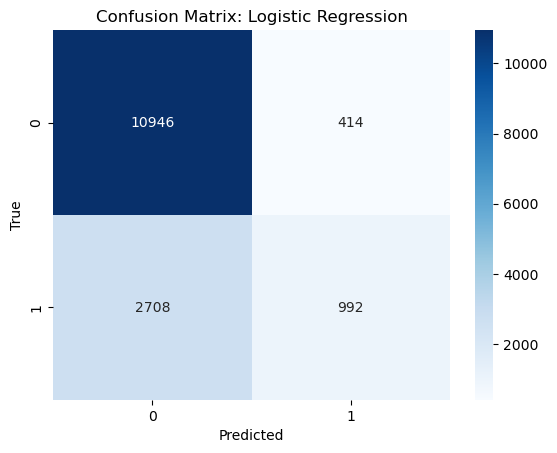

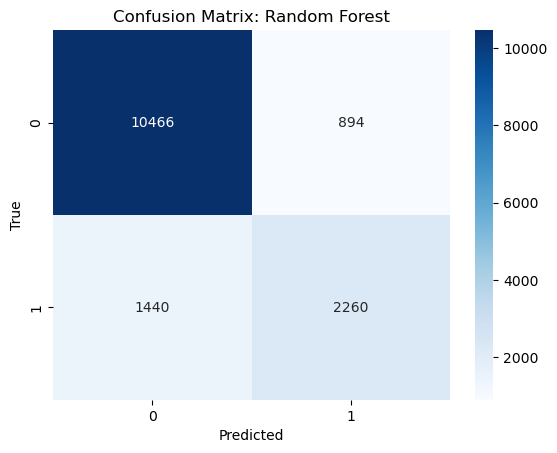

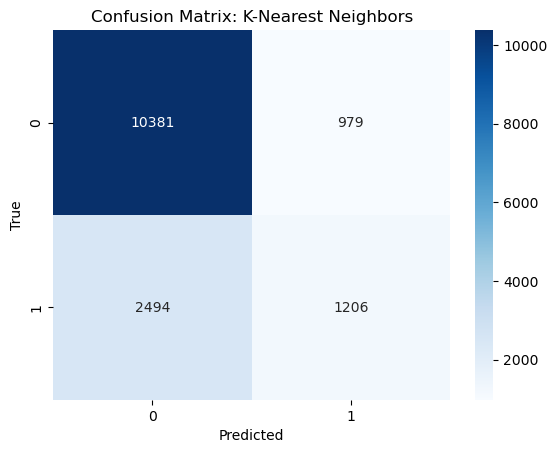

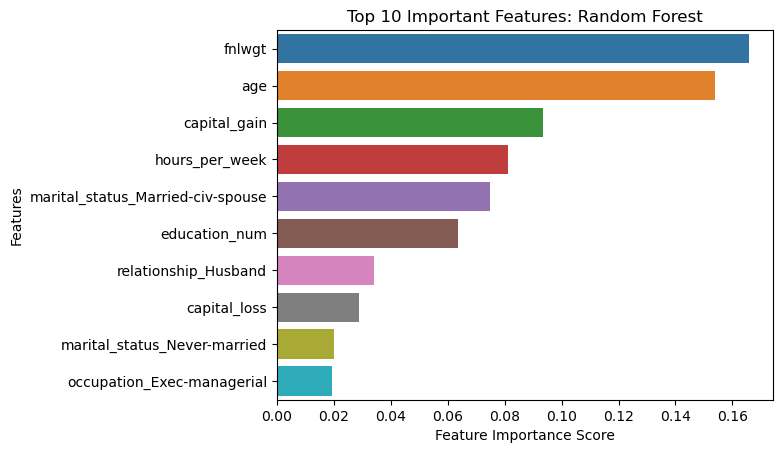

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_test, y_pred, model_name):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.show()

def plot_important_features(importance, columns, model_name, top_n=10):
    feature_importance = pd.Series(importance, index=columns).sort_values(ascending=False)
    important_features = feature_importance[:top_n]
    sns.barplot(x=important_features, y=important_features.index)
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title(f'Top {top_n} Important Features: {model_name}')
    plt.show()

#Plot confusion matrices

plot_confusion_matrix(y_test, lr_pred, "Logistic Regression")
plot_confusion_matrix(y_test, rf_pred, "Random Forest")
plot_confusion_matrix(y_test, knn_pred, "K-Nearest Neighbors")

#Plot feature importance for Random Forest model

plot_important_features(rf_model.feature_importances_, X_train.columns, "Random Forest", top_n=10)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


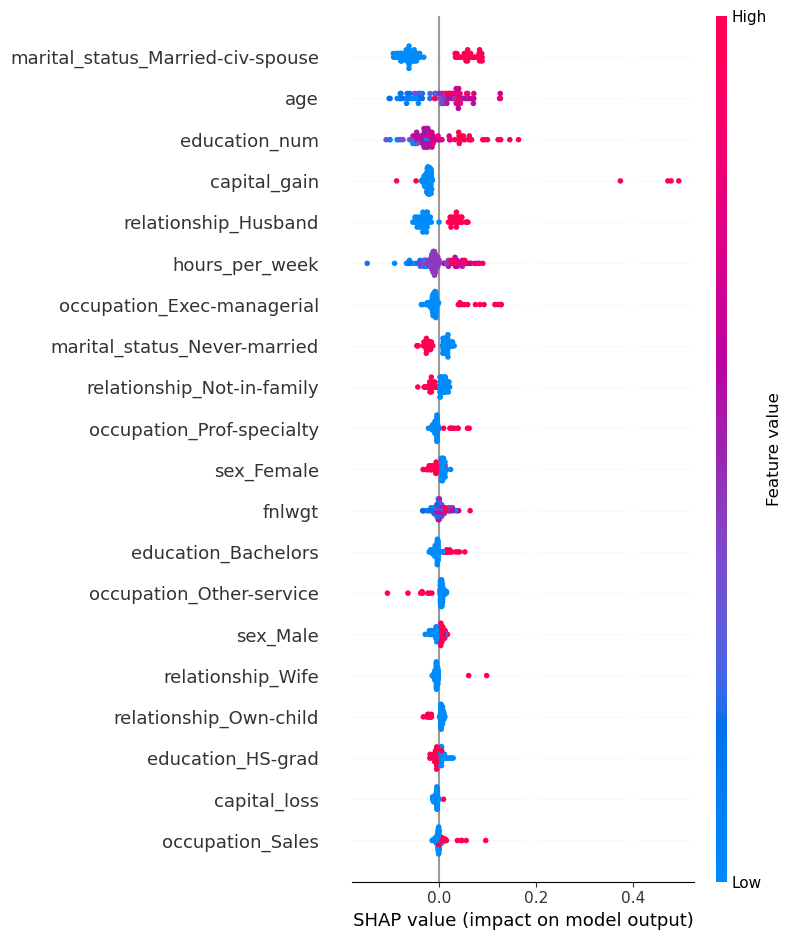

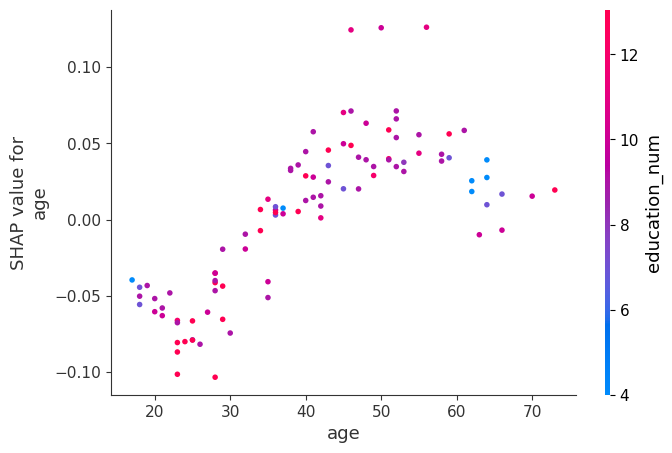

In [21]:
import shap

# Use TreeExplainer for tree-based models like RandomForest, GradientBoosting, and XGBoost
explainer = shap.TreeExplainer(rf_model)

# For other models like Logistic Regression or SVM, use KernelExplainer
# explainer = shap.KernelExplainer(rf_model.predict_proba, X_train)

sample = X_test.sample(100, random_state=42)
shap_values = explainer.shap_values(sample)

# Select an instance (e.g., the first one in the sample)
instance_index = 0

# Plot SHAP values for the selected instance
shap.force_plot(explainer.expected_value[1], shap_values[1][instance_index, :], sample.iloc[instance_index, :], feature_names=sample.columns)

shap.summary_plot(shap_values[1], sample, feature_names=sample.columns)

#The summary plot shows the contribution of each feature towards the prediction for each instance in the sampled test set. The x-axis represents the SHAP values, while the y-axis contains the features sorted by their overall importance.

# Create a SHAP dependence plot for the 'age' feature
feature_name = 'age'
feature_index = sample.columns.get_loc(feature_name)
shap.dependence_plot(feature_index, shap_values[1], sample, feature_names=sample.columns)

#The SHAP dependence plot shows the relationship between the SHAP values (y-axis) and the chosen feature's values (x-axis). Each point represents an instance in the dataset, and the color scale indicates the value of another feature with which the chosen feature interacts the most.

#This plot can help you understand how the chosen feature's values affect the prediction and how this effect changes when considering the interaction with other features.